In [1]:
import pandas as pd
import time
import skimage
from skimage.io import imread, imshow
from skimage import filters
from skimage import feature
from skimage import morphology
from skimage import measure
from skimage import exposure
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import ndimage as ndi
import numpy as np
import pathlib as plb 
import csv
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.util import crop
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from skimage import measure
from skimage.morphology import closing, square, remove_small_objects
from statistics import median

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [128]:
no_insert = imread('/Users/emilyfryer/Documents/Current_analysis/Images/no_insert.tiff')
insert = imread('/Users/emilyfryer/Documents/Current_analysis/Images/insert.tiff')

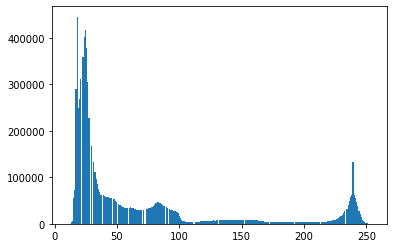

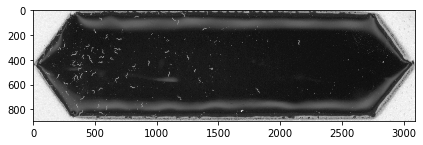

In [129]:
ax = plt.hist(insert.ravel(), bins = 256)
plt.show()
imshow(insert)

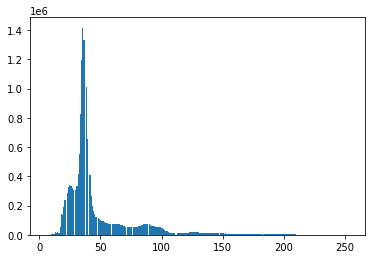

In [130]:
ax = plt.hist(no_insert.ravel(), bins = 256)
plt.show()

In [117]:
base_folder = plb.Path('/Users/emilyfryer/Documents/Current_analysis')
path_img = base_folder.joinpath('Images/SUG_200904_002_Post.tif')
path_rslt = base_folder.joinpath('automated_results')
fig_path = base_folder.joinpath('Figures')

In [118]:

label_begin = time.time()
#os.chdir(path_img)
image=np.invert(imread(path_img))

# apply threshold
print('At threshold')
thresh = filters.threshold_otsu(image)
bw = closing(image > thresh, square(10))

# remove artifacts connected to image border
cleared = remove_small_objects(clear_border(bw), 1000000)
print('Clearing small objects took ', str(int(time.time() - label_begin)), 'seconds.')
#print('Image Cleared')
# label image regions
label_image = label(bw)
print('Feature finding and labeling took ', str(int(time.time() - label_begin)), 'seconds.')
#image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
print('Image Labeled')


At threshold
Clearing small objects took  92 seconds.
Feature finding and labeling took  101 seconds.
Image Labeled


In [119]:

props = regionprops_table(label_image, properties=('label','centroid', 'bbox', 'area'))
dff=pd.DataFrame(props)
#dff.to_csv(path_or_buf=path_rslt.joinpath('dff.csv'))



In [120]:
df_area = dff.sort_values(by=['area'], ascending=False)
df_area.head(20)

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area
0,1,7131,5165,0,0,14039,10200,100871502
3653,3654,3474,9832,2864,9481,3911,10200,102845
14594,14595,11037,552,10494,198,11531,782,96602
6394,6395,5792,9598,5365,9449,6262,9960,86909
3608,3609,3093,9647,2760,9486,3418,9937,75465
4540,4541,4460,9628,3948,9480,4957,9962,74894
8051,8052,6618,2235,6574,1232,6661,3244,74659
10449,10450,7668,2104,7640,1132,7698,3767,62214
20254,20255,13302,1875,13276,1188,13347,2676,46247
1819,1820,899,3769,863,2946,929,4665,44763


In [121]:
wells = df_area[df_area.area>= 20000 ]

In [122]:
print(len(wells))

20


In [22]:
whl_img = wells.iloc[0]
wells = wells.iloc[1:]
wells=wells.sort_values(by=['bbox-1'])
wells

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area
359,360,8315,2859,7881,1309,8748,4410,2370454
436,437,9718,2904,9278,1347,10155,4451,2376680
20,21,1580,2894,1133,1348,2033,4434,2368495
574,575,12645,2901,12191,1357,13107,4448,2357268
489,490,11169,2901,10727,1358,11612,4442,2375092
98,99,2998,2912,2561,1363,3437,4453,2381548
277,278,5916,2913,5472,1371,6360,4462,2379436
194,195,4501,2913,4063,1372,4941,4460,2381559
183,184,4471,7354,4034,5824,4914,8887,2371174
340,341,8269,7397,7832,5876,8712,8934,2377214


In [23]:
print(len(wells))

16


In [24]:
up_low = median(wells['bbox-0'])
l_r = median(wells['bbox-1'])

In [25]:
wells.reset_index(drop=True, inplace=True)

In [26]:


#df.to_csv(path_or_buf=path_rslt.joinpath('df.csv'))
# Sort the plates into the left and right
mask1 = wells['bbox-1'] > l_r
df_r = wells[mask1]
df_l = wells[~mask1]


In [27]:

## Split the right plates to upper (#1) and lower (#4)
dffr=df_r.sort_values(by=['bbox-0'])
dffr.reset_index(drop=True, inplace=True)


mask2 = df_r['bbox-0'] > up_low

dff4 = df_r[mask2]
dff1 = df_r[~mask2]

In [28]:
dff1

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area
8,184,4471,7354,4034,5824,4914,8887,2371174
11,26,1574,7406,1140,5883,2011,8950,2353568
13,284,5915,7420,5482,5891,6357,8959,2355284
14,117,3043,7409,2590,5892,3498,8942,2370566


In [29]:

### Sort the wells on each plate
df1=dff1.sort_values(by=['bbox-0'])
df4=dff4.sort_values(by=['bbox-0'])
df4.reset_index(drop=True, inplace=True)
df1.reset_index(drop=True, inplace=True)


In [30]:
## Split the left plates to upper (#2) and lower (#3)
dffl=df_l.sort_values(by=['bbox-0'])
dffl.reset_index(drop=True, inplace=True)
#MinCol2=1.05*list(dffl.items())[3][1][3]
mask = df_l['bbox-0'] > up_low
dff3 = df_l[mask]
dff2 = df_l[~mask]

In [31]:
### Sort the wells on each plate
df2=dff2.sort_values(by=['bbox-0'])
df3=dff3.sort_values(by=['bbox-0'])
df3.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

In [36]:
df3

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area
0,360,8315,2859,7881,1309,8748,4410,2370454
1,437,9718,2904,9278,1347,10155,4451,2376680
2,490,11169,2901,10727,1358,11612,4442,2375092
3,575,12645,2901,12191,1357,13107,4448,2357268


In [37]:
## Update the label of each well
new_label_1 = pd.Series(['1P', '1Q','1R','1S'], name='label', index=[0,1,2,3])
df1.update(new_label_1)

new_label_2 = pd.Series(['2P', '2Q','2R','2S'], name='label', index=[0,1,2,3])
df2.update(new_label_2)

new_label_3 = pd.Series(['3P', '3Q','3R','3S'], name='label', index=[0,1,2,3])
df3.update(new_label_3)

new_label_4 = pd.Series(['4P', '4Q','4R','4S'], name='label', index=[0,1,2,3])
df4.update(new_label_4)



In [38]:
### Append the dataframes
df_f=df1.append(df2, ignore_index=True).append(df3, ignore_index=True).append(df4, ignore_index=True)
df_f["Chemotaxis"] = np.nan
df_f

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area,Chemotaxis
0,1P,1574,7406,1140,5883,2011,8950,2353568,NaN
1,1Q,3043,7409,2590,5892,3498,8942,2370566,NaN
2,1R,4471,7354,4034,5824,4914,8887,2371174,NaN
3,1S,5915,7420,5482,5891,6357,8959,2355284,NaN
4,2P,1580,2894,1133,1348,2033,4434,2368495,NaN
5,2Q,2998,2912,2561,1363,3437,4453,2381548,NaN
6,2R,4501,2913,4063,1372,4941,4460,2381559,NaN
7,2S,5916,2913,5472,1371,6360,4462,2379436,NaN
8,3P,8315,2859,7881,1309,8748,4410,2370454,NaN
9,3Q,9718,2904,9278,1347,10155,4451,2376680,NaN


In [52]:
df_f = df_f.rename(columns={'label': 'WellNo'})
df_f.head()

,WellNo,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area,Chemotaxis
0,1P,1574,7406,1140,5883,2011,8950,2353568,NaN
1,1Q,3043,7409,2590,5892,3498,8942,2370566,NaN
2,1R,4471,7354,4034,5824,4914,8887,2371174,NaN
3,1S,5915,7420,5482,5891,6357,8959,2355284,NaN
4,2P,1580,2894,1133,1348,2033,4434,2368495,NaN


In [115]:
def loopWell(df_f,image,path_rslt, fig_path):

    for well in range(len(df_f)):

#     fin_image = image[ df_f[][]:Lower_boundary , Left_boundary:Right_boundary ]
        new_image=np.invert(image)
        fin_image = new_image[ df_f['bbox-0'][well]:df_f['bbox-2'][well], df_f['bbox-1'][well]:df_f['bbox-3'][well]]
        wellno = df_f['WellNo'][well]
        image_dims = fin_image.shape
        print(wellno)

        
        thresh = skimage.filters.threshold_otsu(fin_image)
        binarized = closing(fin_image > thresh, square(10))
        #imshow(binarized)
        
        ## Find features in binary image
        labeled_array, num_features = ndi.label(binarized)
        #all_regions = measure.regionprops(label_image=labeled_array, intensity_image=fin_image,
        #                                  coordinates='rc')
        
        props_worm = regionprops_table(label_image=labeled_array, properties=('label','centroid', 'area'))
        worms=pd.DataFrame(props_worm)
        
        # label image regions
        #label_image = label(cleare)
        #image_label_overlayy = label2rgb(label_image, image=fin_image, bg_label=0)
        filt_worm=worms[worms['area']<2000]
        filtered_worm=filt_worm[filt_worm['area']>50]


        print(len(filtered_worm))
        
        fig, axes = plt.subplots(figsize=(8, 16), constrained_layout=True)
        axes.imshow(binarized)

#sns.scatterplot(x='X', y='Y', ax=axes, data=auto_dat, color='red', edgecolor='none', legend=False )
        axes.set_title(wellno)
        sns.scatterplot(x='centroid-1', y='centroid-0', ax=axes, data=filtered_worm, s=10,color='red',edgecolor='none', legend=False )
        fig.savefig(fig_path.joinpath(wellno + ".tif"), orientation='landscape')
        #w_df=pd.DataFrame(all_regions)
        #filtered_regions = []
        #for region in all_regions:
          #  area = region.area

           # if area >= 90 and area <=1000 and region.major_axis_length < 150:
          #      filtered_regions.append(region)
        #print(worms)

        #calc_chemotaxis_index(df_f,filtered_worm,path_rslt,well,image_dims)
        #save_worm_locations(df_f,filtered_worm,path_rslt,label)
    #save_Summary(df_f)

1P
357
1Q
347
1R
278
1S
280
2P
216
2Q
336
2R
369
2S
262
3P
419
3Q
342
3R
157
3S
208
4P
120
4Q
268
4R
252
4S
248


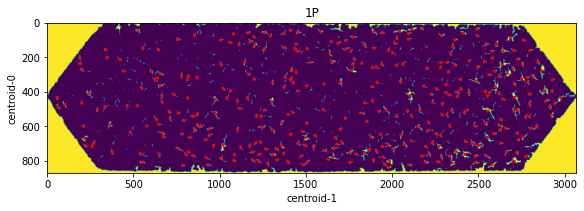

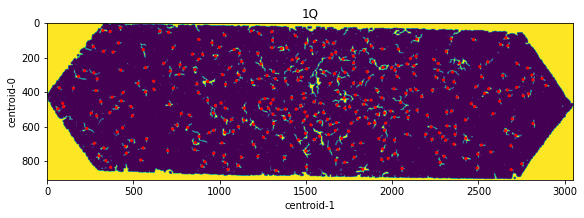

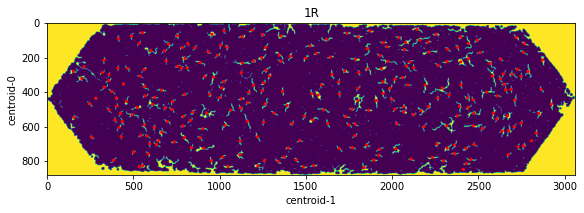

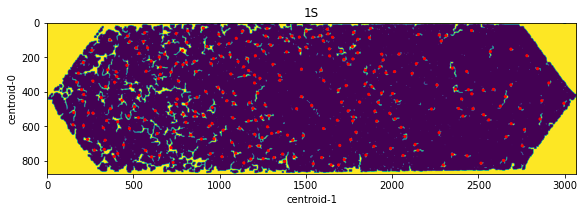

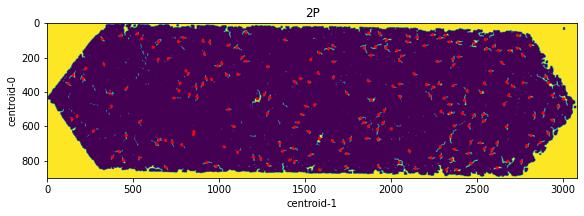

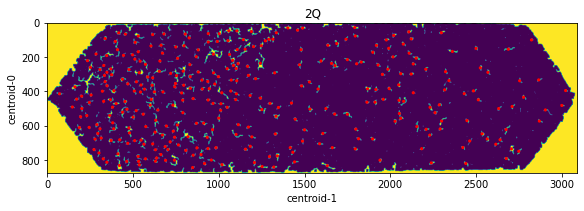

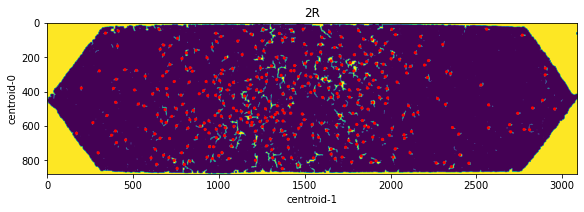

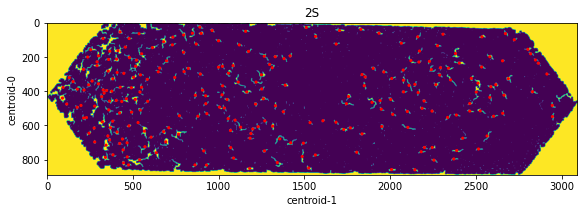

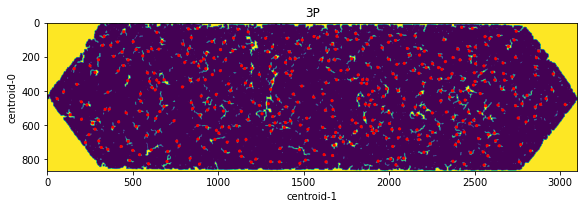

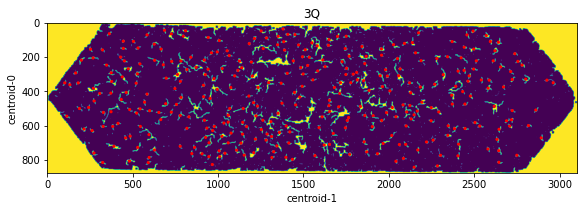

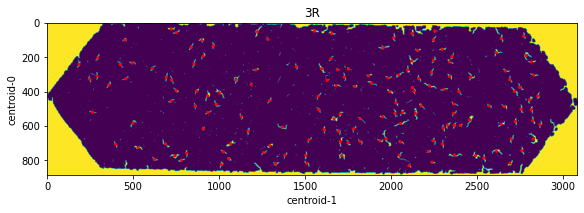

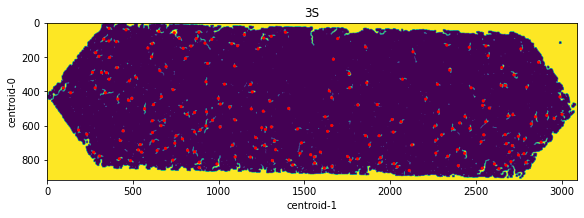

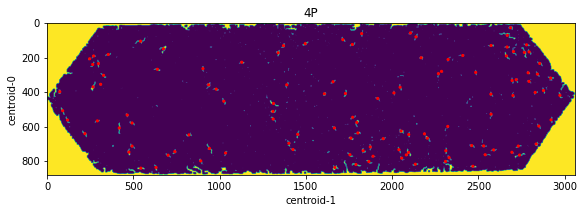

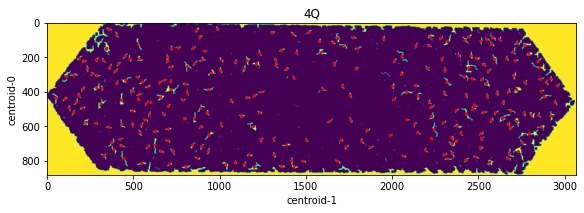

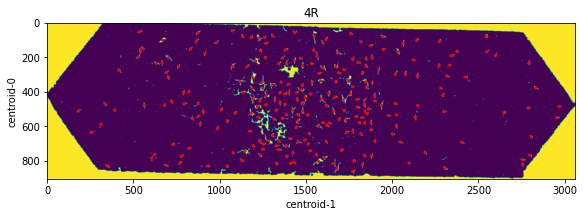

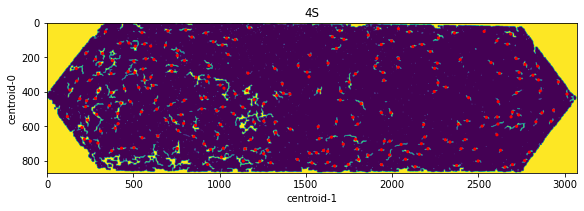

In [116]:

loopWell(df_f,image,path_rslt, fig_path)


In [41]:
def save_worm_locations(filename, worms):
    with open(filename, 'w', newline='') as csvfile:
        worm_writer = csv.writer(csvfile, delimiter=',')
        worm_writer.writerow([' ','X','Y']) # header row

        worm_num = 1
        for worm in worms:
            worm_writer.writerow([worm_num, worm.centroid[1], worm.centroid[0]])
            worm_num += 1

In [42]:
def calc_chemotaxis_index(df_f,filtered_worm,path_rslt,well, dims):
    
    ## Assign features to zones of the plate
    left_area_boundary = int(4/9*dims[1])#int(3424*4/9) #8000
    print(left_area_boundary)
    right_area_boundary = int(5/9*dims[1])#int(3424*5/9)
    print(right_area_boundary)

    left_side_worms = filtered_worm[filtered_worm['centroid-1'] <= left_area_boundary]
    middle_w = filtered_worm[filtered_worm['centroid-1'] < right_area_boundary]
    middle_worms = middle_w[middle_w['centroid-1'] >left_area_boundary]
    right_side_worms = filtered_worm[filtered_worm['centroid-1'] >= right_area_boundary]

    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(filtered_worm)
    #print('Left; ' + str(worms_in_left_region) + '   Right: ' + str(worms_in_right_region))

    chemotaxis_index = ((worms_in_left_region - worms_in_right_region) 
                        / (worms_in_left_region + worms_in_right_region))
    df_f['Chemotaxis'][well]=chemotaxis_index

In [43]:
def save_Summary(df_f,wellno):
    #os.chdir(path_rslt)
    filename = wellno + '.csv'
    with pd.to_csv(filename, mode='a') as writer:  
        df_f.to_excel(writer, sheet_name='Sum')

In [44]:
center_mass = (df['centroid-1'][0], df['centroid-0'][0])
print(center_mass)
fig, ax = plt.subplots()
ax.imshow(image)
# Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
ax.scatter(center_mass[0], center_mass[1], s=160, c='C0', marker='+')
plt.show()

NameError: name 'df' is not defined